In [2]:
# Camera callibration
# https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/a30f45cb-c1c0-482c-8e78-a26604841ec0

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

%matplotlib inline

objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# chess board dimensions
nx, ny = 9, 6

# prepare objects
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Read in an image
# Note: If you read in an image using matplotlib.image.imread() 
# you will get an RGB image, but if you read it in using OpenCV cv2.imread() this will give you a BGR image.

images = glob.glob('camera_cal/calibration*.jpg')

for name in images:
    img = mpimg.imread(name)

    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, draw corners
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

    else:
        print('no corners')
        
        
# callibrate camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


no corners
no corners
no corners


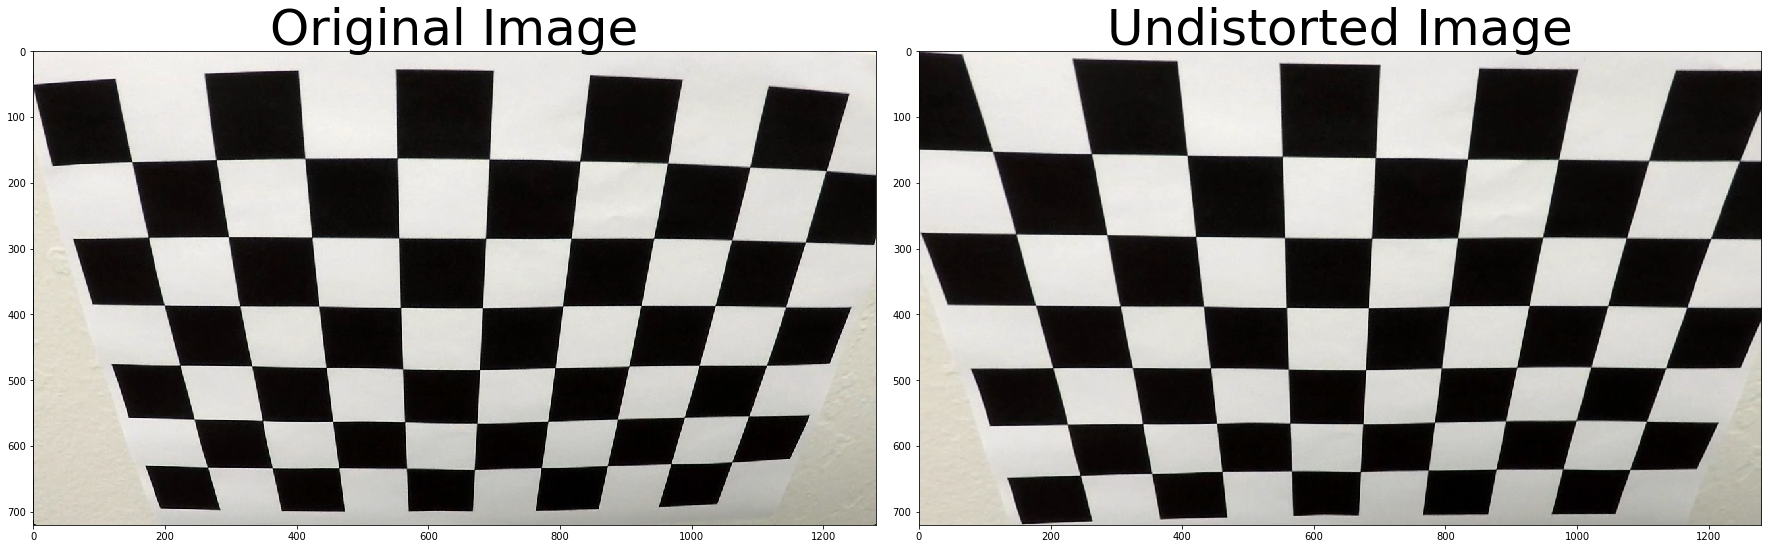

In [3]:
# Camera callibration test on test calibration image
#%matplotlib inline

# using one of the calibration images as test images
image_name = 'calibration2.jpg'
img = mpimg.imread('camera_cal/' + image_name)

def plot_orig_and_undistort(src, dst, image_name, save= False):
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(src)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    plt.show()

    if save:
        f.savefig('output_images/undistorted_' + image_name)
    

undistorted = cv2.undistort(img, mtx, dist, None, mtx)   
plot_orig_and_undistort(img, undistorted, image_name, save=True)
#mpimg.imsave('output_images/' + image_name, undistorted)

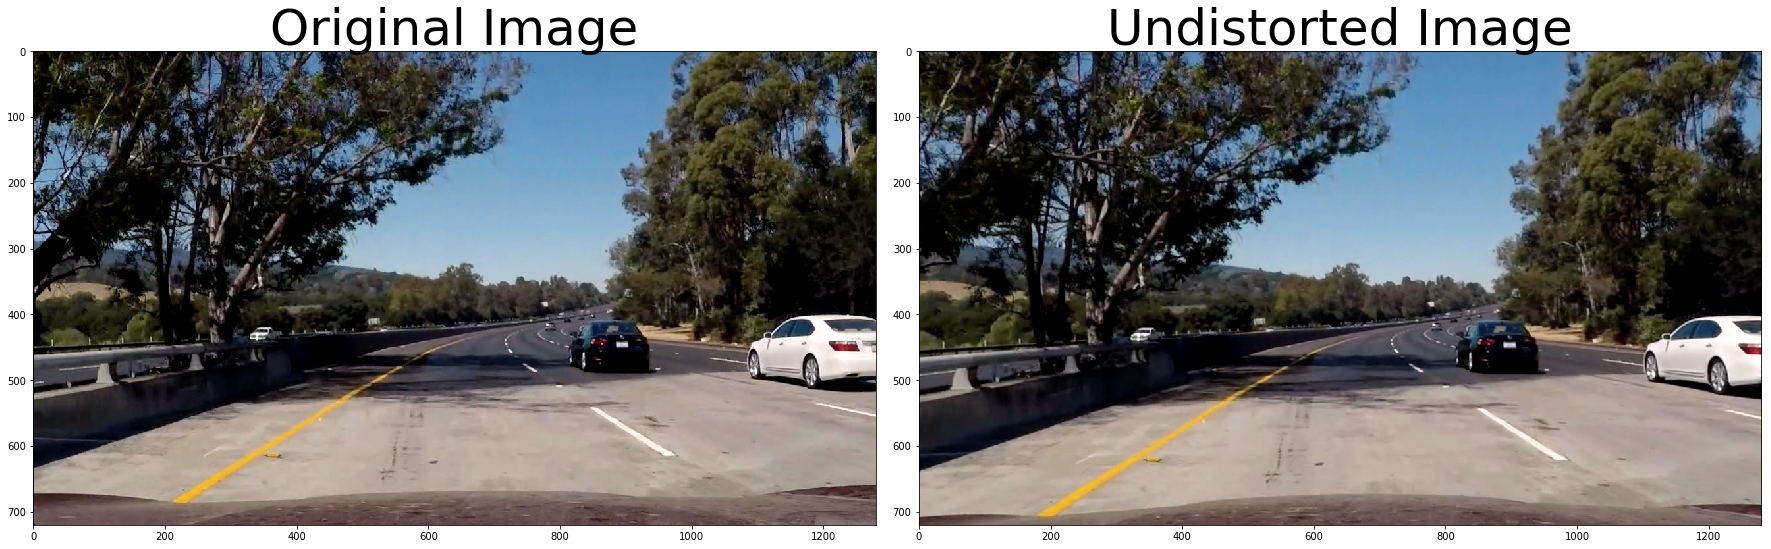

In [4]:
# Undistort road image

image_name = 'test5.jpg'
img = mpimg.imread('test_images/' + image_name)
undistorted = cv2.undistort(img, mtx, dist, None, mtx)    
plot_orig_and_undistort(img, undistorted, image_name, save=True)


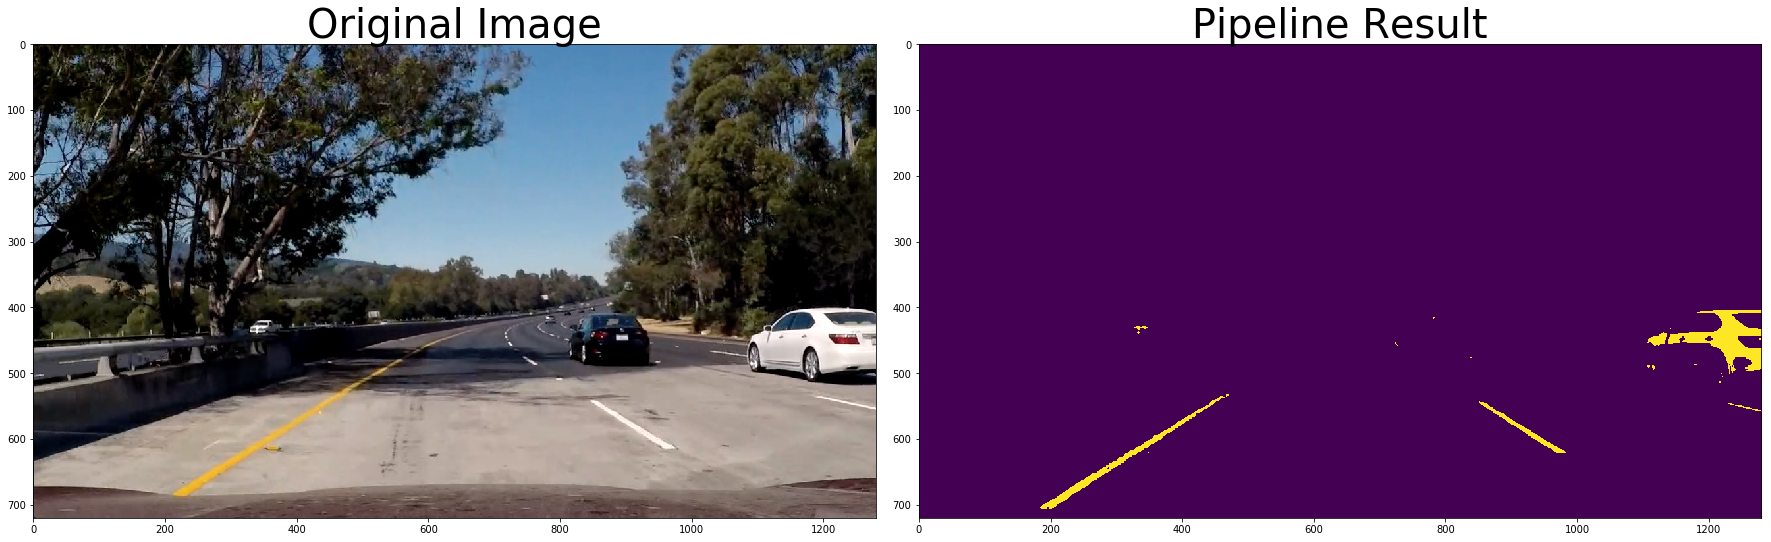

In [5]:
# gradient and color transforms of road image

def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100), h_thresh=(20, 100),
             v_thresh=(240, 255), r_thresh=(220,255),
             l_thresh=(230,255), b_thresh=(255,255)):
    
    img = np.copy(img)
    
    # Convert to HLS color space and separate the S and L channels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1

    #R and V channels are strong component of yellow and white
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    v_channel = hsv[:,:,2]
    r_channel = img[:,:,0]
    
    # Threshold color channel
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= v_thresh[0]) & (v_channel <= v_thresh[1])] = 1
    
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= r_thresh[0]) & (r_channel <= r_thresh[1])] = 1
    
    # Convert to LUV color space and separate the L channel, good for whites
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV).astype(np.float)
    l_channel = luv[:,:,0]
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    # Convert to LAB color space and separate the B channel, good for yellows
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB).astype(np.float)
    b_channel = lab[:,:,2]
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh[0]) & (b_channel <= b_thresh[1])] = 1
    
    # combine colors and gradient
    color_binary = np.zeros_like(sxbinary)
    # color_binary[(s_binary == 1) | (sxbinary == 1) ] = 1
    #color_binary[(s_binary == 1) | (v_binary == 1) #| (sxbinary == 1)
    #             | (r_binary == 1) | (l_binary == 1) | (b_binary == 1)] = 1
    
    color_binary[#(s_binary == 1) # best
                 ((r_binary == 1) & (h_binary == 1)) # lines
                 | (l_binary == 1) # white
                 | ((v_binary == 1) & (b_binary == 1)) # yellow
                ] = 1 
                 

    #return sxbinary
    return color_binary
    
result = pipeline(undistorted, s_thresh=(170, 255), sx_thresh=(20, 100))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

f.savefig('output_images/test1-gradient-threshold.jpg')

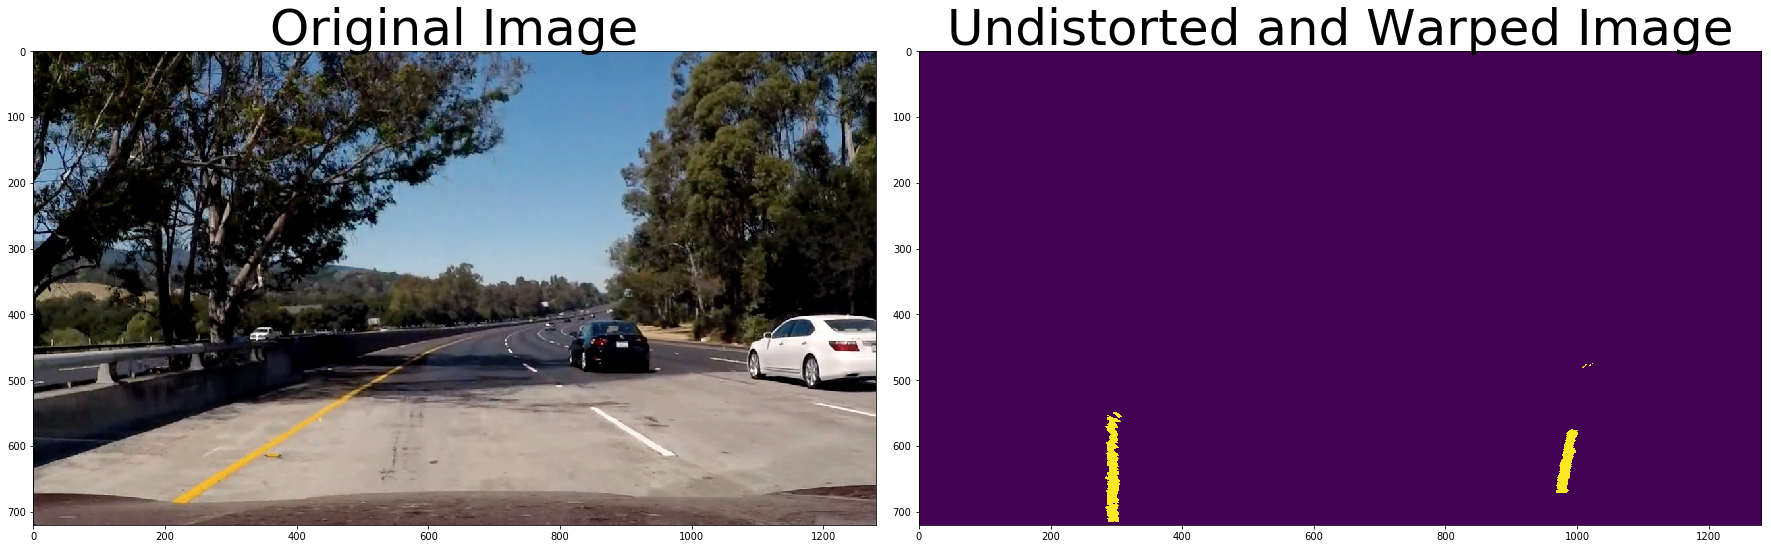

In [6]:
# Perspective transform on road image

def warper(img, mtx, dist): 
    
    img_size = (img.shape[1], img.shape[0])
            
    src = np.float32(
     [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
     [((img_size[0] / 6) - 10), img_size[1]],
     [(img_size[0] * 5 / 6) + 60, img_size[1]],
     [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    
    dst = np.float32(
     [[(img_size[0] / 4), 0],
     [(img_size[0] / 4), img_size[1]],
     [(img_size[0] * 3 / 4), img_size[1]],
     [(img_size[0] * 3 / 4), 0]])

                                     
    # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # e) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, M

warped, perspective_M = warper(result, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

f.savefig('output_images/test1-perspective-transform.jpg')


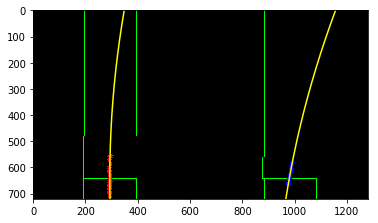

In [7]:
# Use sliding window approach to fit polynomials

def fit_polynomials(warped):
    
    binary_warped = warped

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 


    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return ploty, left_fitx, right_fitx, left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy, leftx, lefty, rightx, righty

ploty, left_fitx, right_fitx, left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy, leftx, lefty, rightx, righty = fit_polynomials(warped)

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
    
f.savefig('output_images/test1-polynomial-fit.jpg')

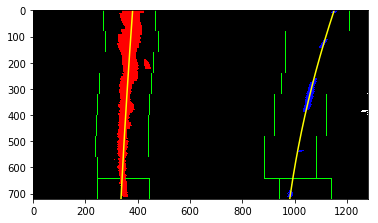

In [341]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!

def fit_polynomials_lite(warped, left_fit, right_fit):
    
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return ploty, left_fitx, right_fitx, left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy, leftx, lefty, rightx, righty

ploty, left_fitx, right_fitx, left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy, leftx, lefty, rightx, righty = fit_polynomials_lite(warped, left_fit, right_fit)

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
    
f.savefig('output_images/test1-polynomial-fit-lite.jpg')

In [8]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

3749.34677137 3474.99282891


In [9]:


def curvature(lefty, leftx, righty, rightx):
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    return (left_curverad, right_curverad)

print(ploty.shape, leftx.shape, rightx.shape)
(left_curverad, right_curverad) = curvature(lefty, leftx, righty, rightx)
print(left_curverad, 'm', right_curverad, 'm')



(720,) (2532,) (1569,)
1230.7091823 m 1101.3646366 m


In [10]:
def compute_offset(leftx, rightx):
    
    # compute offset in px
    car_center = 640 # px
    
    lane_left = np.mean(leftx)
    lane_right = np.mean(rightx)
    
    lane_center = lane_left + (lane_right - lane_left) / 2.
    
    offset = car_center - lane_center
    
    # transfrom offset to m
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    return offset * xm_per_pix
    
offset = compute_offset(leftx, rightx)
print(offset, 'm')

0.00779163036541 m


In [11]:
class Line():
    def __init__(self):
        
        # was the line detected in the last iteration?
        self.detected = False  
        
        # to account for specially difficult locations
        self.consecutively_undetected = 0
        
        # x values of the last n fits of the line
        # self.recent_xfitted = [] 
        
        #average x values of the fitted line over the last n iterations
        # self.bestx = None
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fitx = None  
        
        #polynomial coefficients for the most recent fit
        #self.current_fit = [np.array([False])]  
        self.last_fitx = None
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        #x values for detected line pixels
        #self.allx = None  
        #y values for detected line pixels
        #self.ally = None
        
        
        self.max_iterations = 10
        self.gamma = 0.6
        
    
    def get_detected(self):
        return self.detected
    
    # check if we already have history
    def is_empty(self):
        return (self.best_fitx is None)
    
     
    def update_stats(self, fitx, r, o):
        
        # update moving average
        if self.best_fitx is None:
            self.best_fitx = fitx
        else:
            self.best_fitx = (1 - self.gamma) * self.best_fitx + self.gamma * self.best_fitx
        
        # update last values
        self.last_fitx = fitx 
        self.radius_of_curvature = r # m
        self.line_base_pos = o
            
    # get estimates
    def get_avg_data(self):
        
        fitx = self.last_fitx if self.consecutively_undetected <= 1 else self.best_fitx   
        return (fitx, self.radius_of_curvature, self.line_base_pos)
    
    # check if polynomial coefficients between the current and last frames are similar
    def similar_poly(self, fitx):
        
        self.diffs = np.subtract(self.last_fitx, fitx)
        
        return (abs(np.mean(self.diffs)) < 0.1)
    
    # 
    def process_data(self, fitx, r, o, lane_detected):
        
        # detection: similar curvature between lines, acceptable lane width
        # small deviation between current line and previous line
        
        similar_poly = False if self.is_empty() else self.similar_poly(fitx)
            
        self.detected = lane_detected & similar_poly
                    
        # reset and smoothing if necessary
        if self.detected is False or self.is_empty() is True:
            # update stats
            self.update_stats(fitx, r, o)   
            self.consecutively_undetected = 0
        else:
            self.consecutively_undetected += 1
    
l = Line()

In [12]:
def lane_detected(leftx, lefty, left_curverad, right_curverad):
    
    # curvatures should be similar
    if abs(left_curverad - right_curverad) > 700:
        return False, ''
    
    # lane width should be close to real value of 3.7m
    lane_width = abs(np.mean(leftx) - np.mean(rightx))
    
    # transfrom to m
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    lane_width *= xm_per_pix
    
    if lane_width > 5 or lane_width < 2:
        return False, lane_width
    
    return (True, lane_width)

res, lane_width = lane_detected(leftx, lefty, left_curverad, right_curverad)
print(res, left_curverad, right_curverad, lane_width)

True 1230.7091823 1101.3646366 3.64588864177


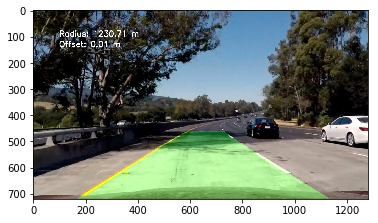

In [13]:
# overlay lane into image

def display_lane(warped, left_curverad, offset, left_fitx, right_fitx, ploty, perspective_M, img):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, np.linalg.inv(perspective_M), (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    # display radius and offset
    #(left_curverad, right_curverad) = curvature(lefty, leftx, righty, rightx)
    txt = 'Radius: ' + str(round(left_curverad,2)) + ' m'
    cv2.putText(result,txt,(100,100), cv2.FONT_HERSHEY_SIMPLEX, 1, 
                color=(255,255,255), thickness=2, lineType=cv2.LINE_AA)
    
    txt = 'Offset: ' + str(round(offset,2)) + ' m'
    cv2.putText(result,txt,(100,140), cv2.FONT_HERSHEY_SIMPLEX, 1, 
                color=(255,255,255), thickness=2, lineType=cv2.LINE_AA)

    return result


result = display_lane(warped, left_curverad, offset, left_fitx, right_fitx, ploty, perspective_M, undistorted)
fig = plt.figure()
plt.imshow(result)
fig.savefig('output_images/test1-lane-overlap.jpg')

In [14]:
# complete pipeline

left_line = Line()
right_line = Line()

def process_frame(img):
    
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    
    result = pipeline(undistorted, s_thresh=(170, 255), sx_thresh=(20, 100))
    
    warped, perspective_M = warper(result, mtx, dist)
    
    ploty, left_fitx, right_fitx, left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy, leftx, lefty, rightx, righty = fit_polynomials(warped)
    
    # sanity check
    (left_curverad, right_curverad) = curvature(lefty, leftx, righty, rightx)
    offset = compute_offset(leftx, rightx)
    detected, lane_width = lane_detected(leftx, lefty, left_curverad, right_curverad)
        
    # update line data
    left_line.process_data(left_fitx, left_curverad, offset, detected)
    right_line.process_data(right_fitx, right_curverad, offset, detected)
    
    # get smoothed past values if needed
    if left_line.get_detected() is False:
        (left_fitx, left_curverad, offset) = left_line.get_avg_data()
    if right_line.get_detected() is False:
        (right_fitx, right_curverad, offset) = right_line.get_avg_data()
    
    return display_lane(warped, left_curverad, offset, left_fitx, right_fitx, ploty, perspective_M, undistorted)
    

In [46]:
a = np.array([[1,2,3]])
print(a)
b = np.array([[1,2,3]])
a = np.append(a, b, axis=0)
print(a)
avg = np.average(a, axis=0)
print(avg)

c = np.array([0.1,2,0.3])
d = np.array([1,1,1])

c = c*0.3 + d*0.1
print(c)
            


[[1 2 3]]
[[1 2 3]
 [1 2 3]]
[ 1.  2.  3.]
[ 0.13  0.7   0.19]


straight_lines1.jpg
straight_lines2.jpg
test1.jpg
test2.jpg
test3.jpg
test4.jpg
test5.jpg
test6.jpg


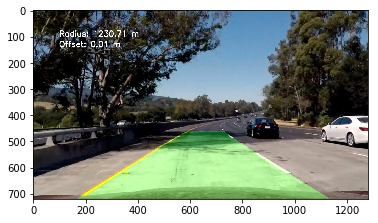

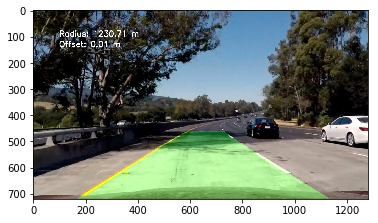

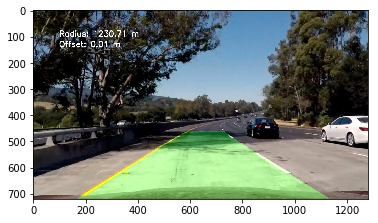

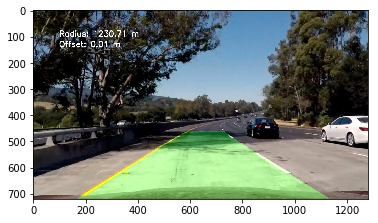

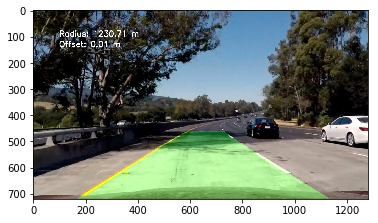

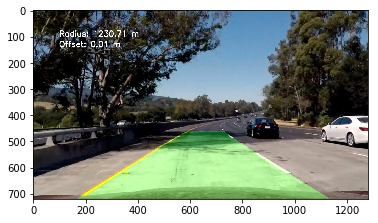

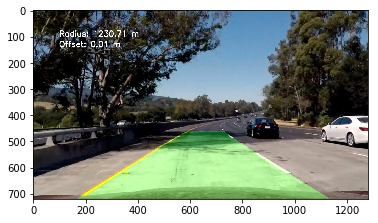

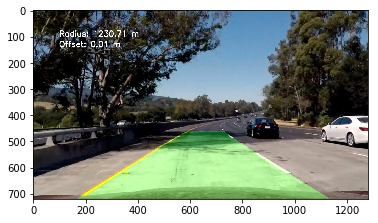

In [15]:
# apply complete pipeline to all test images

import os

for image in os.listdir("test_images/"):
    
    print(image)
    img = mpimg.imread('test_images/' + image)
    
    fig = plt.figure()
    result = process_frame(img)
    plt.imshow(result)
    
    fig.savefig('output_images/overlap_' + image)
    



In [17]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

v_output = 'output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(v_output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [05:47<00:00,  4.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 6min 32s, sys: 2min 8s, total: 8min 41s
Wall time: 5min 48s


In [162]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(v_output))